# PythonによるPrincipal Curveの実装 (bendingアルゴリズム)
> 

- toc: true 
- badges: true
- comments: true
- author: 山拓
- categories: [statistics]

この記事はPythonで**Principal Curves** (Hastie & Stuetzle, 1989)を実装するという内容です。数学的な詳細は優曇華院による記事「[Principal Curve 入門](https://salad-bowl-of-knowledge.github.io/hp/statistics/2019/09/29/princurve.html)」を読んでください。

## Principal Curvesとは
Principal curvesは簡単に言えば**主成分分析** (principal component analysis, PCA) の**非線形版**です。非線形次元圧縮としては他にKernel PCAやLLE (Locally Linear Embedding), ISOMAP (Isometric Feature Map), LEM (Laplacian Eigenmap), tSNE (t-distributed Stochastic Neighbor Embedding), UMAP (Uniform Manifold Approximation and Projection) などがあります。

Principal curves (高次元であれば **Principal surface**) の特徴としては

1. PCAの曲線 (曲面) への一般化 (データ点との距離を最小化する曲線 (曲面))
2. グローバルな情報も保持できる

などがあります。

具体例を示しておきます。2次元上の点$(x_0, x_1)\in \mathbb{R}^2$が次のようにサンプリングされたとします。 

$$
\begin{aligned}
x_0 & \sim U(-1, 1)\\ 
x_1 & = x_0^5 + \xi\ \ (\xi \sim \mathcal{N}(0, 0.15^2)) 
\end{aligned}
$$

ただし、$U$は一様分布、$\mathcal{N}$は正規分布です。このような点を100個描画したのが、下図(左)です。 下図(中央)はPCAをしたときの結果であり、青線は第一主成分軸を表します。点群との間の線は点から第一主成分軸に下ろした垂線です。 下図(右)は同じ点群に対するPrincipal curveです。PCAよりもデータセットの特徴を適切に捉えることができています。

![img1](images/princurve2_figs/1570352090.png)

## bendingアルゴリズム

Rのpackageは[princurve](https://cran.r-project.org/web/packages/princurve/index.html)があるのですが、Pythonにはありません。そこで、今回は (Hastie & Stuetzle, 1989) によるPrincipal curvesの基本となる**bendingアルゴリズム**を実装します。

$p$次元の$n$個のデータ$\boldsymbol{x}_i \in \mathbb{R}^{p}\ \ (i=1, 2, \cdots, n)$があるとし、点$\boldsymbol{x}_i$の集合を$\boldsymbol{X}$とします。さらに$\boldsymbol{f}(\lambda)=[f_1(\lambda), \cdots, f_p(\lambda)]$を$\lambda
\in \mathbb{R}$を媒介変数とする$\mathbb{R}^p$上の曲線とします。この$\boldsymbol{f}$がprincipal curveとなります。また、媒介変数$\lambda$は一方の端点を基準点としたときの曲線上の位置 (基準点からの距離)を表します。さらに $\lambda_{\boldsymbol{f}}(\boldsymbol{x}_i)\ \
(i=1,2,\cdots, n)$ を$\boldsymbol{x}_i$と$\boldsymbol{f}(\lambda)$の距離を最小化する$\lambda$の中で最大の$\lambda$とします。数式で表すと 

$$ 
\lambda_{\boldsymbol{f}}(\boldsymbol{x})=\sup_\lambda\left\{\lambda :\|
\boldsymbol{x}-\boldsymbol{f}(\lambda)\|=\inf_\mu\|\boldsymbol{x}-\boldsymbol{f}(\mu)\|\right\} 
$$

となります。ただし、$\|\cdot\|$はユークリッドノルムを意味します。この$\lambda_f(\boldsymbol{x})$をprojection indexと呼びます。

さて、このprincipal curveを求めるためのbendingアルゴリズムは次のように表記されます(Hastie and Stuetzle, 1989; Kegl, et al., 2000)。

- [Step 0] $\boldsymbol{f}^{(0)}(\lambda)$を$\boldsymbol{X}$の第一主成分線とし、$j=1$とする。
- [Step 1] $\boldsymbol{f}^{(j)}(\lambda)=E(\boldsymbol{X}\mid\lambda_{\boldsymbol{f}^{(j-1)}}=\lambda)$とする。
- [Step 2] $\lambda^{(j)}(\boldsymbol{X})=\lambda_{\boldsymbol{f}^{(j)}}(\boldsymbol{X})$とする。
- [Step 3] $D^2(\boldsymbol{X},\boldsymbol{f}^{(j)})=
    E(\|\boldsymbol{X}-\boldsymbol{f}^{(j)}(\lambda^{(j)}(\boldsymbol{X}))$を計算する。$|D^2(\boldsymbol{X},\boldsymbol{f}^{(j)})-D^2(\boldsymbol{X},\boldsymbol{f}^{(j-1)})|$がある閾値以下となれば (つまり収束した場合)、
    $\boldsymbol{f}=\boldsymbol{f}^{(j)}$として終了する。そうでない場合、$j\leftarrow j+1$としてStep 1に戻る。

ここで、Step1は<b>Expectation Step</b>と呼ばれ、$\lambda_{\boldsymbol{f}^{(j-1)}}=\lambda$という条件の下でのデータ点$\boldsymbol{x}_i$の平均(条件付き期待値)を求めます。
ただし、これはデータの分布が既知、あるいは無限個のサンプルを仮定する場合であるので、データ$\boldsymbol{X}$の分布が未知の場合にはLocally weighted regressionや3次スプライン曲線(cubic smoothing splines)で置き換えます。 またStep2は <b>Projection
Step</b>と呼ばれ、データ点$\boldsymbol{x}_i$から最も近い曲線上の点の$\lambda$を求め、その$\lambda$を$\lambda^{(j)}(\boldsymbol{x}_i)$とします。

## bendingアルゴリズムの実装

### 初期化

まず、toyデータセットを生成し、PCAを実行します。このときの第一主成分軸がPrincipal curveの初期関数です。なお、点群から第一主成分軸へ下ろした垂線の描画は「[Matplotlibで複数の線分を描画する方法](https://omedstu.jimdofree.com/2019/10/04/matplotlibで複数の線集合を描画する方法/)」を参考にしてください。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.interpolate import UnivariateSpline

In [2]:
# Generate toy data
np.random.seed(0)
n_samples = 100
x0 = np.random.uniform(-1, 1, size=n_samples)
x1 = x0**5 + 0.15*np.random.randn(n_samples)
X = np.vstack((x0, x1)).T

In [3]:
# SVD
u, s, v = np.linalg.svd(X)
  
# 主成分上へのXの射影
expand_v = np.expand_dims(v[0], axis=1)
Z = X @ expand_v @ expand_v.T
  
# 元データから射影への直線のリスト
lines = [[(X[i, 0], X[i, 1]),
          (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
lc = mc.LineCollection(lines, colors="k", linewidths=1)

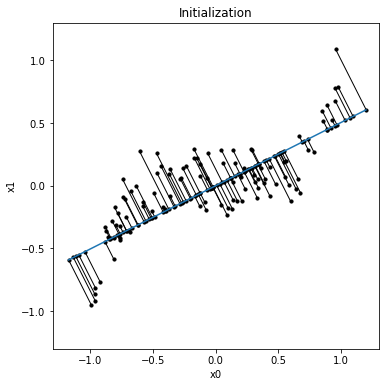

In [4]:
# 主成分軸の描画用変数
xmax = ymax = 1.3
xmin = ymin = -1.3
zs = np.arange(Z[:, 0].min(), Z[:, 0].max(), 1e-2)
  
# 描画
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(aspect='1') #こうしないと線が傾いて見える
ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k') # 元データのplot
ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k') # 射影のplot
ax.add_collection(lc)
ax.plot(zs, v[0, 1] / v[0, 0] * zs) # 主成分軸
plt.title("Initialization")
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel('x0'); plt.ylabel('x1')
plt.show()

ここでデータ点と曲線(今は第一主成分線)との距離を計算し、さらに$\lambda_{\boldsymbol{f}^{(j)}}(\boldsymbol{X})$の初期値`lam`も計算します(これは主成分線の 一方の端点からの距離を意味します)。また、各種定数も定義します。

In [5]:
D2 = np.sum((X-Z)**2)
print("D^2:", D2)
 
lam = u[:,0]*s[0] # lambdaの初期値
lam_plus = 0.01 # iterごとに伸長するlamの長さ
n_seq_lam = int(1e4) # 離散化した曲線の点の数

D^2: 4.45390390507273


ここからはStep1からStep3までを実装します。実際にはループを用いるのですが、まずは一度だけStep1～3を実行する場合を考えます。

### Expectation Step

Step1のExpectation Stepでは$\lambda_{\boldsymbol{f}^{(j-1)}}(\boldsymbol{x}_i)$に対する$\boldsymbol{x}_i$のスプライン曲線$(\in \mathbb{R}^p)$を$\boldsymbol{f}^{(j)}(\lambda)$の近似とします。
スプライン曲線のために `scipy.interpolate.UnivariateSpline` を用い、 このインスタンスに `lam` と `X[:, 0]` または`X[:, 1]` を渡します。ただし、`lam` は完全に増加している必要があるので、
重複を削除し、昇順に並び替えます。このとき対応する<code>X</code>のデータもスプライン曲線の生成から除外します。 また、`seq_lam` は$\lambda$を均等に取った配列です。ただし、ステップごとに曲線の長さを伸長するために<code>lam</code>の値域から少し大きくしたものとしています。

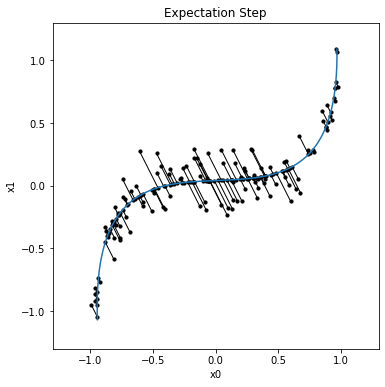

In [6]:
"""
Expectation Step:
    曲線上に射影されるデータ点の平均（正確には条件付期待値）を求める
    Xの分布が未知の場合にはLocally weighted regressionや
    cubic smoothing splinesで置き換えられる
"""
sorted_lam, lam_idx = np.unique(lam, return_index=True)
f0 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 0],
                      k=3, s=None)
f1 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 1],
                      k=3, s=None)
 
seq_lam = np.linspace(lam.min()-lam_plus,
                      lam.max()+lam_plus, n_seq_lam)
f_points = np.vstack((f0(seq_lam), f1(seq_lam))).T
Z = np.vstack((f0(lam), f1(lam))).T
 
# 描画
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(aspect='1')
ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
lines = [[(X[i, 0], X[i, 1]),
          (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
lc = mc.LineCollection(lines, colors="k", linewidths=1)
ax.add_collection(lc)
ax.plot(f_points[:, 0], f_points[:, 1])
plt.title("Expectation Step")
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel('x0'); plt.ylabel('x1')
plt.show()

### Projection Step
Projection Stepではデータ点と曲線上の点の距離を計算し、距離が最小となる点の$\lambda$である $\lambda_{\boldsymbol{f}^{(j)}}(\boldsymbol{X})$を新しい$\lambda^{(j)}(\boldsymbol{X})$とします。

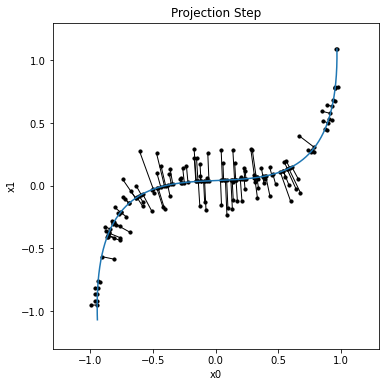

D^2: 1.688773139900023


In [7]:
"""
Projection Step:
    データ点から最も近い曲線上の点を求める
    最適化問題を解かせてもよいが、ステップを小さく取り、距離が最小の点を取る
"""
f_ = np.repeat(np.expand_dims(f_points, 0),
               n_samples, axis=0)
X_ = np.repeat(np.expand_dims(X, 1), n_seq_lam, axis=1)
dist = np.sum((f_ - X_)**2, axis=2) # 点と関数の距離
min_dist_idx = np.argmin(dist, axis=1) # 距離が最初となるindex
Z = f_points[min_dist_idx] # 射影点の更新
lam = seq_lam[min_dist_idx] # lambdaの更新
 
lines = [[(X[i, 0], X[i, 1]),
          (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
lc = mc.LineCollection(lines, colors="k", linewidths=1)
 
# 描画
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(aspect='1')
ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
ax.add_collection(lc)
ax.plot(f_points[:, 0], f_points[:, 1])
plt.title("Projection Step")
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel('x0'); plt.ylabel('x1')
plt.show()
 
D2 = np.sum((X-Z)**2)
print("D^2:", D2)

### コードの全体と結果
これまで見てきたStep0～Step3ですが、実際にはこれを繰り返します。収束を考えず、単にforループを用いた実装の全体は次のようになります。

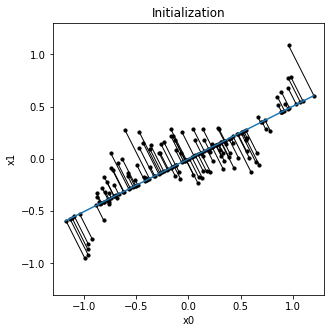

D^2: 4.45390390507273


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.interpolate import UnivariateSpline
  
# Generate toy data
np.random.seed(0)
n_samples = 100
x0 = np.random.uniform(-1, 1, size=n_samples)
x1 = x0**5 + 0.15*np.random.randn(n_samples)
X = np.vstack((x0, x1)).T
  
# SVD
u, s, v = np.linalg.svd(X)
  
# 主成分上へのXの射影
expand_v = np.expand_dims(v[0], axis=1)
Z = X @ expand_v @ expand_v.T
  
# 元データから射影への直線のリスト
lines = [[(X[i, 0], X[i, 1]),
          (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
lc = mc.LineCollection(lines, colors="k", linewidths=1)
  
# 主成分軸の描画用変数
xmax = ymax = 1.3
xmin = ymin = -1.3
zs = np.arange(Z[:, 0].min(), Z[:, 0].max(), 1e-2)
  
# 描画
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(aspect='1') #こうしないと線が傾いて見える
ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k') # 元データのplot
ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k') # 射影のplot
ax.add_collection(lc)
ax.plot(zs, v[0, 1] / v[0, 0] * zs) # 主成分軸
plt.title("Initialization")
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel('x0'); plt.ylabel('x1')
plt.show()
 
D2 = np.sum((X-Z)**2)
print("D^2:", D2)

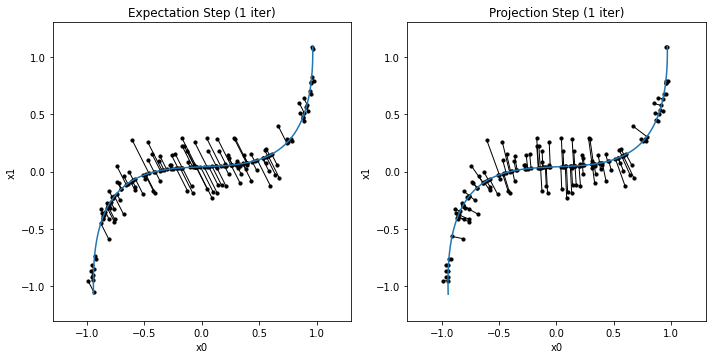

D^2: 1.688773139900023


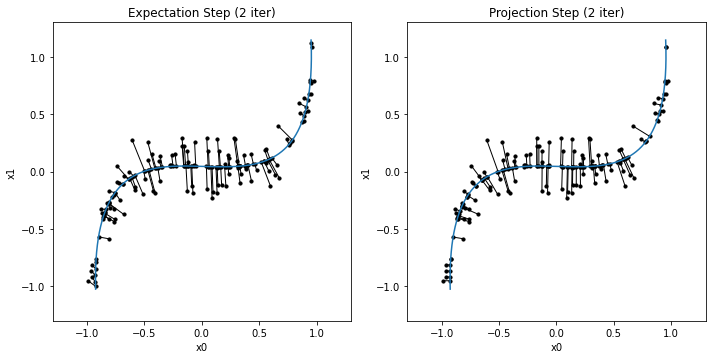

D^2: 1.6072936372827606


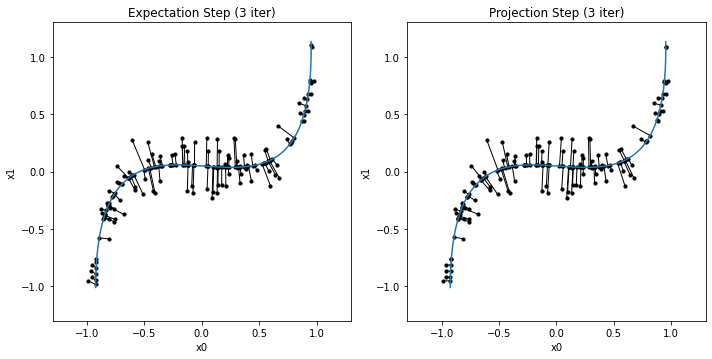

D^2: 1.573855714007582


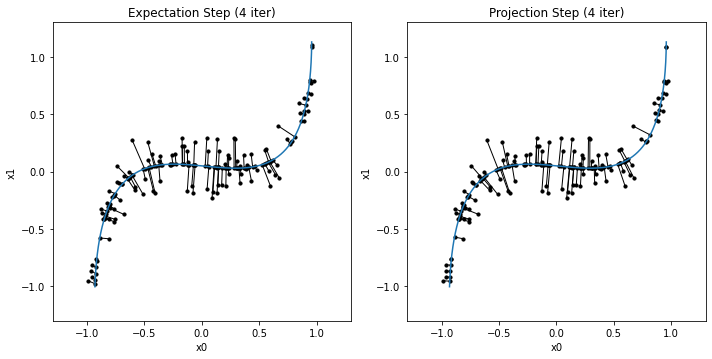

D^2: 1.5521875833071004


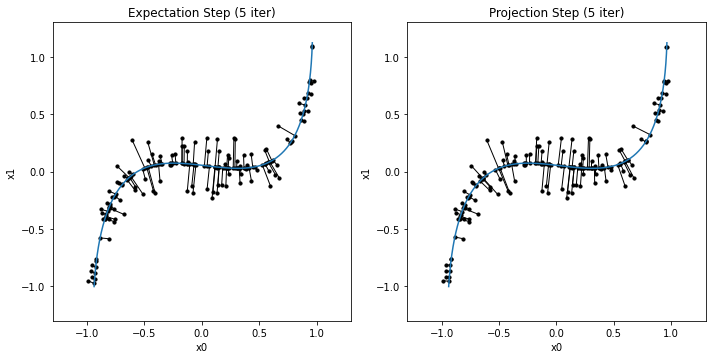

D^2: 1.5358119308800324


In [9]:
D2_list = [] # 点群と曲線の距離の2乗和を記録するリスト
D2_list.append(D2)
 
lam = u[:,0]*s[0] # lambdaの初期値
lam_plus = 0.01 # iterごとに伸長するlamの長さ
n_iter = 5 # 探索の回数
n_seq_lam = int(1e4) # 離散化した曲線の点の数


for i in range(n_iter):
    """
    Expectation Step:
        曲線上に射影されるデータ点の平均（正確には条件付期待値）を求める
        Xの分布が未知の場合にはLocally weighted regressionや
        cubic smoothing splinesで置き換えられる
    """
    sorted_lam, lam_idx = np.unique(lam, return_index=True)
    f0 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 0],
                          k=3, s=None)
    f1 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 1],
                          k=3, s=None)
     
    seq_lam = np.linspace(lam.min()-lam_plus,
                          lam.max()+lam_plus, n_seq_lam)
    f_points = np.vstack((f0(seq_lam), f1(seq_lam))).T
    Z = np.vstack((f0(lam), f1(lam))).T
     
    # 描画
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1, aspect='1')
    ax1.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
    ax1.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
    lines = [[(X[i, 0], X[i, 1]),
              (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
    lc = mc.LineCollection(lines, colors="k", linewidths=1)
    ax1.add_collection(lc)
    ax1.plot(f_points[:, 0], f_points[:, 1])
    plt.title("Expectation Step ("+str(i+1)+" iter)")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.xlabel('x0'); plt.ylabel('x1')
     
    """
    Projection Step:
        データ点から最も近い曲線上の点を求める
        最適化問題を解かせてもよいが、ステップを小さく取り、距離が最小の点を取る
    """
    f_ = np.repeat(np.expand_dims(f_points, 0),
                   n_samples, axis=0)
    X_ = np.repeat(np.expand_dims(X, 1), n_seq_lam, axis=1)
    dist = np.sum((f_ - X_)**2, axis=2) # 点と関数の距離
    min_dist_idx = np.argmin(dist, axis=1) # 距離が最初となるindex
    Z = f_points[min_dist_idx] # 射影点の更新
    lam = seq_lam[min_dist_idx] # lambdaの更新
 
    lines = [[(X[i, 0], X[i, 1]),
              (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
    lc = mc.LineCollection(lines, colors="k", linewidths=1)
     
    # 描画
    ax2 = fig.add_subplot(1,2,2, aspect='1')
    ax2.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
    ax2.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
    ax2.add_collection(lc)
    ax2.plot(f_points[:, 0], f_points[:, 1])
    plt.title("Projection Step ("+str(i+1)+" iter)")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.xlabel('x0'); plt.ylabel('x1')
    plt.tight_layout()
    plt.show()

    D2 = np.sum((X-Z)**2)
    D2_list.append(D2)
    print("D^2:", D2)


このコードを実行し、結果の図をgifアニメーションにしたものは次のようになります。

![gif1](images/princurve2_figs/1570367412.gif)

さらにデータ点と曲線の距離の2乗和の変化は次のようになります。

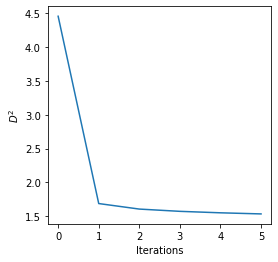

In [10]:
# 点群と曲線の距離の2乗和の変化
plt.figure(figsize=(4, 4))
plt.plot(np.arange(len(D2_list)), np.array(D2_list))
plt.xlabel("Iterations")
plt.ylabel("$D^2$")
plt.show()

ちゃんと収束していることが分かります。

## 様々なデータセットに対するPrincipal curvesの適用例
ここからは他のデータセットにおけるPrincipal curveを求めてみます。

### 円周状に散布された点群

In [ ]:
#collapse-hide

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.interpolate import UnivariateSpline
  
# Generate toy data
np.random.seed(0)
n_samples = 100
r = 1
theta = np.random.uniform(0, 2*np.pi, size=n_samples)
x0 = r*np.cos(theta) + 0.03*np.random.randn(n_samples)
x1 = r*np.sin(theta) + 0.03*np.random.randn(n_samples)
X = np.vstack((x0, x1)).T
  
# SVD
u, s, v = np.linalg.svd(X)
  
# 主成分上へのXの射影
expand_v = np.expand_dims(v[0], axis=1)
Z = X @ expand_v @ expand_v.T
  
# 元データから射影への直線のリスト
lines = [[(X[i, 0], X[i, 1]),
          (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
lc = mc.LineCollection(lines, colors="k", linewidths=1)
  
# 主成分軸の描画用変数
xmax = ymax = 1.3
xmin = ymin = -1.3
zs = np.arange(Z[:, 0].min(), Z[:, 0].max(), 1e-2)
  
# 描画
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(aspect='1') #こうしないと線が傾いて見える
ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k') # 元データのplot
ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k') # 射影のplot
ax.add_collection(lc)
ax.plot(zs, v[0, 1] / v[0, 0] * zs) # 主成分軸
plt.title("Initialization")
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel('x0'); plt.ylabel('x1')
plt.show()
D2 = np.sum((X-Z)**2)
print("D^2:", D2)
 
D2_list = [] # 点群と曲線の距離の2乗和を記録するリスト
D2_list.append(D2)
 
lam = u[:,0]*s[0] # lambdaの初期値
lam_plus = 0.05 # iterごとに伸長するlamの長さ
n_iter = 8 # 探索の回数
n_seq_lam = int(1e4) # 離散化した曲線の点の数
for i in range(n_iter):
    """
    Expectation Step:
        曲線上に射影されるデータ点の平均（正確には条件付期待値）を求める
        Xの分布が未知の場合にはLocally weighted regressionや
        cubic smoothing splinesで置き換えられる
    """
    sorted_lam, lam_idx = np.unique(lam, return_index=True)
    f0 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 0],
                          k=3, s=None)
    f1 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 1],
                          k=3, s=None)
     
    seq_lam = np.linspace(lam.min()-lam_plus,
                          lam.max()+lam_plus, n_seq_lam)
    f_points = np.vstack((f0(seq_lam), f1(seq_lam))).T
    Z = np.vstack((f0(lam), f1(lam))).T
     
    # 描画
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(aspect='1')
    ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
    ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
    lines = [[(X[i, 0], X[i, 1]),
              (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
    lc = mc.LineCollection(lines, colors="k", linewidths=1)
    ax.add_collection(lc)
    ax.plot(f_points[:, 0], f_points[:, 1])
    plt.title("Expectation Step ("+str(i+1)+" iter)")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.xlabel('x0'); plt.ylabel('x1')
    plt.show()
     
    """
    Projection Step:
        データ点から最も近い曲線上の点を求める
        最適化問題を解かせてもよいが、ステップを小さく取り、距離が最小の点を取る
    """
    f_ = np.repeat(np.expand_dims(f_points, 0),
                   n_samples, axis=0)
    X_ = np.repeat(np.expand_dims(X, 1), n_seq_lam, axis=1)
    dist = np.sum((f_ - X_)**2, axis=2) # 点と関数の距離
    min_dist_idx = np.argmin(dist, axis=1) # 距離が最初となるindex
    Z = f_points[min_dist_idx] # 射影点の更新
    lam = seq_lam[min_dist_idx] # lambdaの更新
 
    lines = [[(X[i, 0], X[i, 1]),
              (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
    lc = mc.LineCollection(lines, colors="k", linewidths=1)
     
    # 描画
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(aspect='1')
    ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
    ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
    ax.add_collection(lc)
    ax.plot(f_points[:, 0], f_points[:, 1])
    plt.title("Projection Step ("+str(i+1)+" iter)")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.xlabel('x0'); plt.ylabel('x1')
    plt.show()
     
    D2 = np.sum((X-Z)**2)
    D2_list.append(D2)
    print("D^2:", D2)
 
# 点群と曲線の距離の2乗和の変化
plt.figure(figsize=(4, 4))
plt.plot(np.arange(len(D2_list)), np.array(D2_list))
plt.xlabel("Iterations")
plt.ylabel("$D^2$")
plt.show()

実行した結果のgifアニメーションは次のようになります。

![gif2](images/princurve2_figs/1570367893.gif)

この例は (Hastie & Stuetzle, 1989)にある例の1つです。同様の結果が再現されています。

なお、seed値を変えると次のようになります。

![gif3](images/princurve2_figs/1570367986.gif)

このように上手くいかない場合もあります。

### 2次元Swiss Roll

In [ ]:
#collapse-hide

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.interpolate import UnivariateSpline
  
# Generate toy data
np.random.seed(0)
n_samples = 100
r = 0.1
theta = np.random.uniform(np.pi, 4*np.pi, size=n_samples)
x0 = r*theta*np.cos(theta)
x1 = r*theta*np.sin(theta)
X = np.vstack((x0, x1)).T
  
# SVD
u, s, v = np.linalg.svd(X)
  
# 主成分上へのXの射影
expand_v = np.expand_dims(v[0], axis=1)
Z = X @ expand_v @ expand_v.T
  
# 元データから射影への直線のリスト
lines = [[(X[i, 0], X[i, 1]),
          (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
lc = mc.LineCollection(lines, colors="k", linewidths=1)
  
# 主成分軸の描画用変数
xmax = ymax = 1.5
xmin = ymin = -1.5
zs = np.arange(Z[:, 0].min(), Z[:, 0].max(), 1e-2)
  
# 描画
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(aspect='1') #こうしないと線が傾いて見える
ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k') # 元データのplot
ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k') # 射影のplot
ax.add_collection(lc)
ax.plot(zs, v[0, 1] / v[0, 0] * zs) # 主成分軸
plt.title("Initialization")
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.xlabel('x0'); plt.ylabel('x1')
plt.show()
D2 = np.sum((X-Z)**2)
print("D^2:", D2)
 
D2_list = [] # 点群と曲線の距離の2乗和を記録するリスト
D2_list.append(D2)
 
lam = u[:,0]*s[0] # lambdaの初期値
lam_plus = 0.01 # iterごとに伸長するlamの長さ
n_iter = 10 # 探索の回数
n_seq_lam = int(1e4) # 離散化した曲線の点の数
for i in range(n_iter):
    """
    Expectation Step:
        曲線上に射影されるデータ点の平均（正確には条件付期待値）を求める
        Xの分布が未知の場合にはLocally weighted regressionや
        cubic smoothing splinesで置き換えられる
    """
    sorted_lam, lam_idx = np.unique(lam, return_index=True)
    f0 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 0],
                          k=3, s=None)
    f1 = UnivariateSpline(x=sorted_lam, y=X[lam_idx, 1],
                          k=3, s=None)
     
    seq_lam = np.linspace(lam.min()-lam_plus,
                          lam.max()+lam_plus, n_seq_lam)
    f_points = np.vstack((f0(seq_lam), f1(seq_lam))).T
    Z = np.vstack((f0(lam), f1(lam))).T
     
    # 描画
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(aspect='1')
    ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
    ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
    lines = [[(X[i, 0], X[i, 1]),
              (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
    lc = mc.LineCollection(lines, colors="k", linewidths=1)
    ax.add_collection(lc)
    ax.plot(f_points[:, 0], f_points[:, 1])
    plt.title("Expectation Step ("+str(i+1)+" iter)")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.xlabel('x0'); plt.ylabel('x1')
    plt.show()
     
    """
    Projection Step:
        データ点から最も近い曲線上の点を求める
        最適化問題を解かせてもよいが、ステップを小さく取り、距離が最小の点を取る
    """
    f_ = np.repeat(np.expand_dims(f_points, 0),
                   n_samples, axis=0)
    X_ = np.repeat(np.expand_dims(X, 1), n_seq_lam, axis=1)
    dist = np.sum((f_ - X_)**2, axis=2) # 点と関数の距離
    min_dist_idx = np.argmin(dist, axis=1) # 距離が最初となるindex
    Z = f_points[min_dist_idx] # 射影点の更新
    lam = seq_lam[min_dist_idx] # lambdaの更新
 
    lines = [[(X[i, 0], X[i, 1]),
              (Z[i, 0], Z[i, 1])] for i in range(n_samples)]
    lc = mc.LineCollection(lines, colors="k", linewidths=1)
     
    # 描画
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(aspect='1')
    ax.scatter(X[:, 0], X[:, 1], s=10, marker='o', color='k')
    ax.scatter(Z[:, 0], Z[:, 1], s=10, marker='o', color='k')
    ax.add_collection(lc)
    ax.plot(f_points[:, 0], f_points[:, 1])
    plt.title("Projection Step ("+str(i+1)+" iter)")
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.xlabel('x0'); plt.ylabel('x1')
    plt.show()
     
    D2 = np.sum((X-Z)**2)
    D2_list.append(D2)
    print("D^2:", D2)
 
# 点群と曲線の距離の2乗和の変化
plt.figure(figsize=(4, 4))
plt.plot(np.arange(len(D2_list)), np.array(D2_list))
plt.xlabel("Iterations")
plt.ylabel("$D^2$")
plt.show()

実行した結果のgifアニメーションは次のようになります。

![gif4](images/princurve2_figs/1570368156.gif)

今回実装したbendingアルゴリズムでは残念ながらSwiss Rollデータセットに対して上手くprincipal curveを生成することができませんが、principal curveのアルゴリズムによっては正しく多様体学習が行えるようです (Laparra & Malo, 2016).

## 参考文献
- Guedj, B., and Li, L. (2019). **Sequential Learning of Principal Curves: Summarizing Data Streams on the Fly**. ffhal-01796011v2f ([pdf](https://hal.inria.fr/hal-01796011v2/document))
- Hastie, T. and Stuetzle, W. (1989). **Principal Curves**. *JASA*, **84** (406), 502-516. ([pdf](https://web.stanford.edu/~hastie/Papers/principalcurves.pdf))
- Hastie, T., Tibshirani, R., and Friedman, J. (2009). ***T****he Elements of Statistical Learning: Data Mining, Inference, and Prediction***. (2nd ed.). Springer. ([website](https://web.stanford.edu/~hastie/ElemStatLearn//))
- Kegl, B.,Krzyzak, A., Linder, T., and Zeger, K. (2000). **Learning and design of principal curves**. *IEEE*. **22** (3), 281-297. ([pdf](https://www.lri.fr/~kegl/research/PDFs/KeKrLiZe00.pdf))
- Laparra, V., and Malo, J. (2016). **Sequential principal curves analysis**. *arXiv* [preprint], https://arxiv.org/abs/1606.00856. 
- Sorzano, C.O.S., Vargas, J., and Montano A. P. (2014). **A survey of dimensionality reduction techniques**. *arXiv* [preprint], https://arxiv.org/abs/1403.2877.
- Verbeek, J., Vlassis, N., and Krose, B. (2002). **A k-segments algorithm for finding principal curves**. *Pattern Recognition Letters*, Elsevier. **23** (8), 1009–1017. ([pdf](https://hal.inria.fr/inria-00321497/document))
- Rでの実装例：<https://biostatmatt.com/archives/2894>
